In [ ]:
%matplotlib inline
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [ ]:
class ConfigClass():
    train_dir = 'C:\\Users\\jissr\\Desktop\\FP\\faces\\training\\'
    test_dir = 'C:\\Users\\jissr\\Desktop\\FP\\faces\\testing\\'
    train_batch_size = 64
    train_num_epochs = 75

In [ ]:
class SiameseDataset(Dataset):

    def __init__(self, image_folder, transform = None, invert = False):
        self.image_folder = image_folder
        self.transform = transform
        self.invert = invert

    def __getitem__(self, index):
        sample_1 = random.choice(self.image_folder.imgs)
        same_class = random.randint(0, 1)

        if same_class:
            while True:
                sample_2 = random.choice(self.image_folder.imgs)
                if sample_1[1] == sample_2[1]:
                    break
        else:
            while True:
                sample_2 = random.choice(self.image_folder.imgs)
                if sample_1[1] != sample_2[1]:
                    break

        img_1 = Image.open(sample_1[0]).convert("L")
        img_2 = Image.open(sample_2[0]).convert("L")

        if self.invert:
            img_1 = PIL.ImageOps.invert(img_1)
            img_2 = PIL.ImageOps.invert(img_2)

        if self.transform:
            img_1 = self.transform(img_1)
            img_2 = self.transform(img_2)

        return img_1, img_2, torch.from_numpy(np.array([int(sample_1[1] != sample_2[1])], dtype = np.float32))

    def __len__(self):
        return len(self.image_folder.imgs)

In [ ]:
image_folder = dataset.ImageFolder(root=ConfigClass.train_dir)
siamese_dataset = SiameseDataset(image_folder=image_folder,
                                 transform=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]),
                                 invert=False)

In [ ]:
def imshow(img, text=None):
    np_img = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold', bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

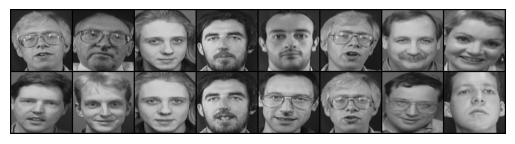

array([[1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
#
dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=0, batch_size=8)
data_iter = iter(dataloader)
vis_batch = next(data_iter)
merged = torch.cat((vis_batch[0], vis_batch[1]), 0)
imshow(torchvision.utils.make_grid(merged))
vis_batch[2].numpy()

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.reflection_pad = nn.ReflectionPad2d(1)
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3)
        self.conv3 = nn.Conv2d(8, 8, kernel_size=3)
        self.relu = nn.ReLU(inplace=True)
        self.batch_norm1 = nn.BatchNorm2d(4)
        self.batch_norm2 = nn.BatchNorm2d(8)
        self.fc1 = nn.Linear(8 * 100 * 100, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 5)

    def forward_one_branch(self, x):
        x = self.batch_norm1(self.relu(self.conv1(self.reflection_pad(x))))
        x = self.batch_norm2(self.relu(self.conv2(self.reflection_pad(x))))
        x = self.batch_norm2(self.relu(self.conv3(self.reflection_pad(x))))
        x = x.view(x.size()[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        return x

    def forward(self, input1, input2):
        output1 = self.forward_one_branch(input1)
        output2 = self.forward_one_branch(input2)

        return output1, output2

In [ ]:
class ConstrastiveLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(ConstrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        distance = F.pairwise_distance(output1, output2, keepdim=True)
        contrastive_loss = torch.mean((1 - label)*torch.pow(distance, 2)
                                      + (label)*torch.pow(torch.clamp(self.margin - distance, min=0.0), 2))

        return contrastive_loss

In [ ]:
#
print(image_folder.imgs[:5])  # Check the first few samples


[('C:\\Users\\jissr\\Desktop\\FP\\faces\\training\\s1\\1.pgm', 0), ('C:\\Users\\jissr\\Desktop\\FP\\faces\\training\\s1\\1.pgm.png', 0), ('C:\\Users\\jissr\\Desktop\\FP\\faces\\training\\s1\\10.pgm', 0), ('C:\\Users\\jissr\\Desktop\\FP\\faces\\training\\s1\\10.pgm.png', 0), ('C:\\Users\\jissr\\Desktop\\FP\\faces\\training\\s1\\2.pgm', 0)]


In [ ]:
#
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


PyTorch version: 2.5.1+cpu
CUDA available: False


In [ ]:

# Ensure PyTorch uses CPU
device = torch.device("cpu")

# Define your model and move it to CPU
model = SiameseNetwork().to(device)

# Define the loss function and optimizer
criterion = ConstrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# DataLoader configuration
dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=0, batch_size=ConfigClass.train_batch_size)



In [ ]:
iteration = 0
loss_history = []
counter = []

Epoch: 1/75 	 Loss: 9.0320
Epoch: 1/75 	 Loss: 5.2885
Epoch: 1/75 	 Loss: 3.3612
Epoch: 1/75 	 Loss: 3.1692
Epoch: 1/75 	 Loss: 3.1165
Epoch: 1/75 	 Loss: 0.7755
Epoch: 2/75 	 Loss: 2.4270
Epoch: 2/75 	 Loss: 1.8013
Epoch: 2/75 	 Loss: 0.9020
Epoch: 2/75 	 Loss: 1.5857
Epoch: 2/75 	 Loss: 1.9517
Epoch: 2/75 	 Loss: 0.4408
Epoch: 3/75 	 Loss: 1.3736
Epoch: 3/75 	 Loss: 0.7824
Epoch: 3/75 	 Loss: 0.8796
Epoch: 3/75 	 Loss: 0.4603
Epoch: 3/75 	 Loss: 0.4144
Epoch: 3/75 	 Loss: 0.2645
Epoch: 4/75 	 Loss: 0.6237
Epoch: 4/75 	 Loss: 0.4027
Epoch: 4/75 	 Loss: 0.2889
Epoch: 4/75 	 Loss: 0.3216
Epoch: 4/75 	 Loss: 0.2834
Epoch: 4/75 	 Loss: 0.3759
Epoch: 5/75 	 Loss: 0.3427
Epoch: 5/75 	 Loss: 0.2793
Epoch: 5/75 	 Loss: 0.1651
Epoch: 5/75 	 Loss: 0.2509
Epoch: 5/75 	 Loss: 0.2802
Epoch: 5/75 	 Loss: 0.3163
Epoch: 6/75 	 Loss: 0.1993
Epoch: 6/75 	 Loss: 0.2444
Epoch: 6/75 	 Loss: 0.2193
Epoch: 6/75 	 Loss: 0.2062
Epoch: 6/75 	 Loss: 0.2071
Epoch: 6/75 	 Loss: 0.1949
Epoch: 7/75 	 Loss: 0.2598
E

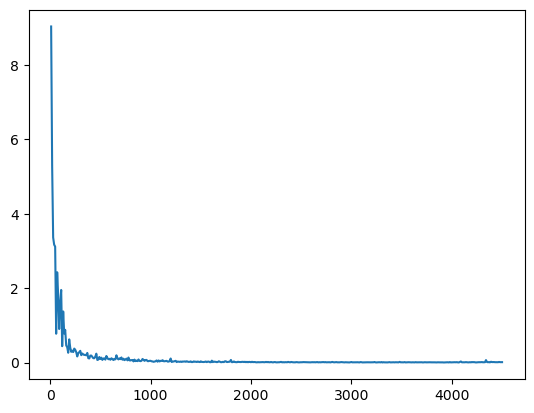

In [ ]:
# Training loop (on CPU)
for epoch in range(ConfigClass.train_num_epochs):
    for i, data in enumerate(dataloader, 0):
        input1, input2, label = data


        optimizer.zero_grad()

        # Forward pass
        output1, output2 = model(input1, input2)

        # Compute contrastive loss
        contrastive_loss = criterion(output1, output2, label)

        # Backward pass
        contrastive_loss.backward()
        optimizer.step()

        # Print loss every 10 iterations
        if (i+1) % 2 == 0:
            print(f"Epoch: {epoch+1}/{ConfigClass.train_num_epochs} \t Loss: {contrastive_loss.item():.4f}")

            iteration += 10
            loss_history.append(contrastive_loss.item())
            counter.append(iteration)

# Plot the loss over time
show_plot(counter, loss_history)


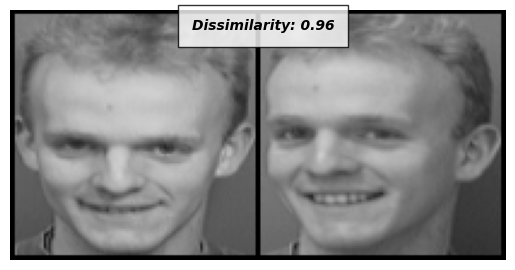

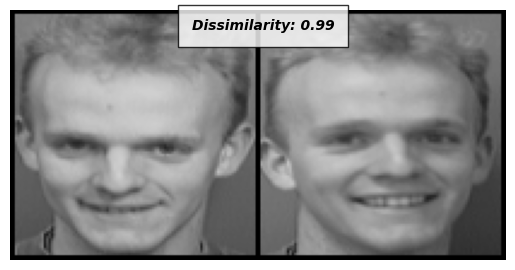

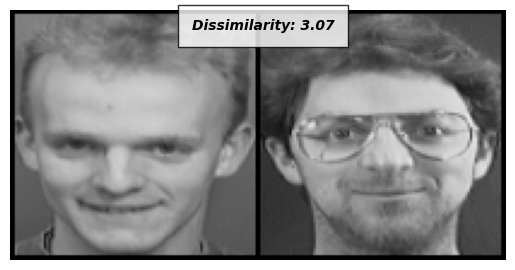

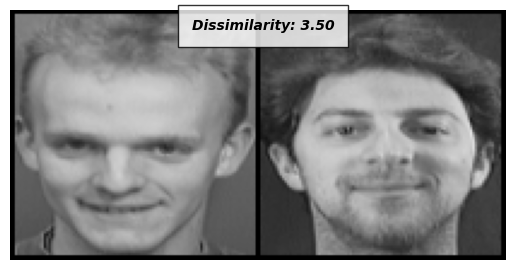

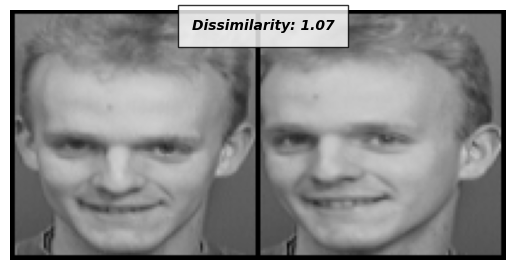

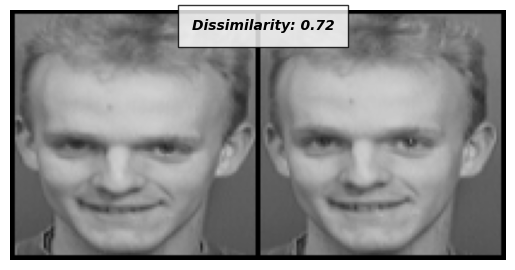

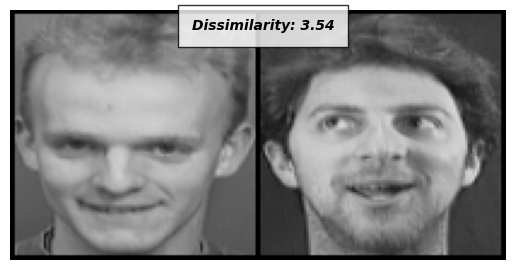

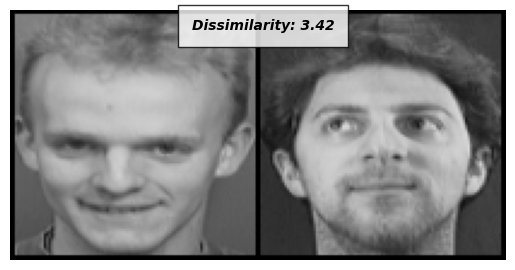

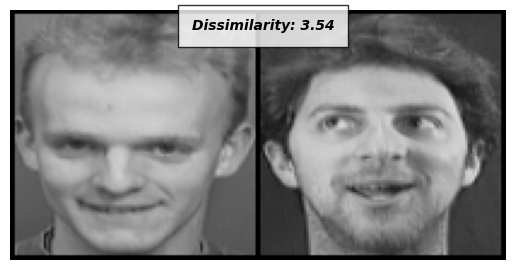

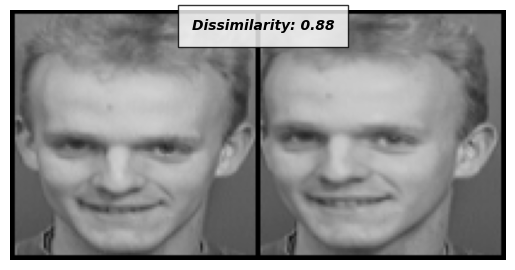

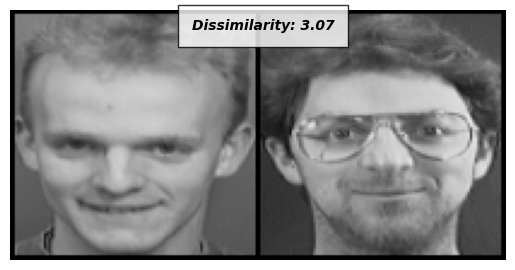

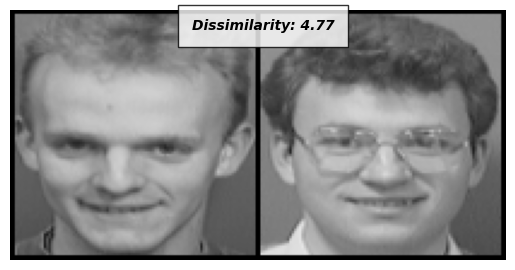

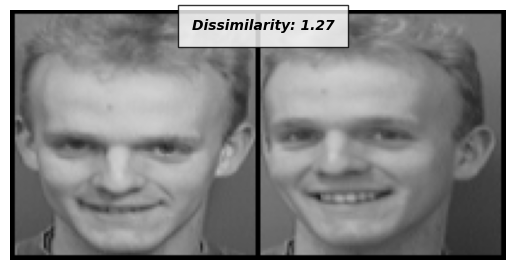

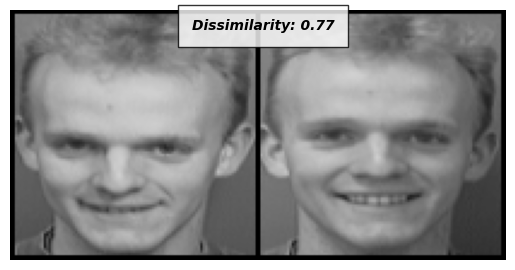

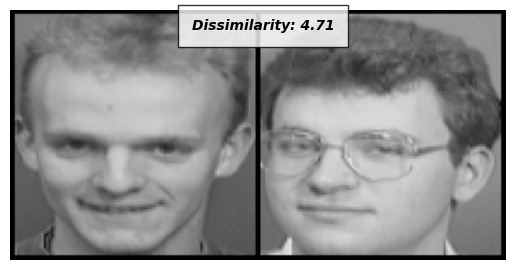

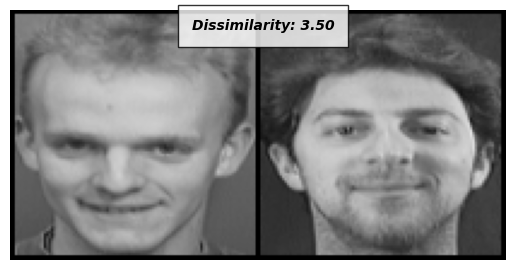

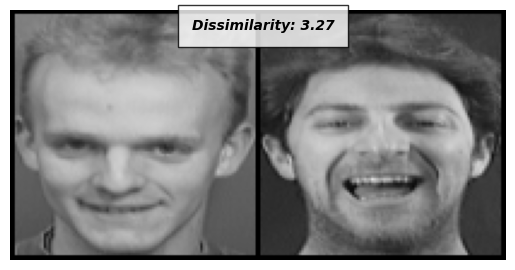

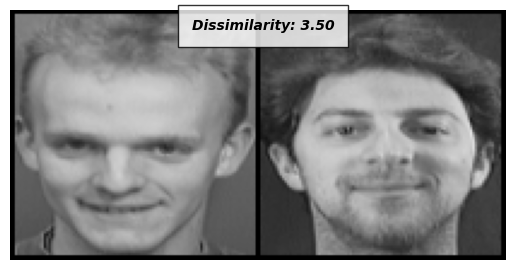

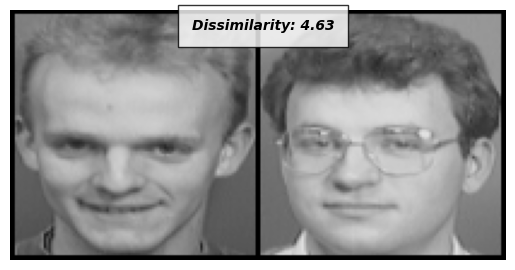

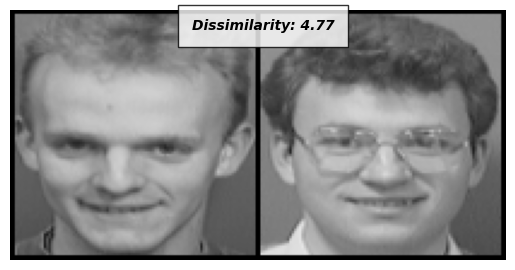

In [ ]:
#
test_folder = dataset.ImageFolder(root=ConfigClass.test_dir)
siamese_dataset = SiameseDataset(image_folder=test_folder,
                                 transform=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]),
                                 invert=False)

dataloader = DataLoader(siamese_dataset, num_workers=0, batch_size=1, shuffle=True)
data_iter = iter(dataloader)
img0, _, _ = next(data_iter)

for i in range(20):
    _, img1, label = next(data_iter)
    merged = torch.cat((img0, img1), 0)

    # Ensure model is running on CPU
    output1, output2 = model(Variable(img0), Variable(img1))  # No .cuda()
    distance = F.pairwise_distance(output1, output2)

    # Display the images with dissimilarity score
    imshow(torchvision.utils.make_grid(merged), 'Dissimilarity: {:.2f}'.format(distance.item()))


Enter the file path of the image to compare:  "C:\\Users\\jissr\\Desktop\\FP\\faces\\testing\\s5\\1.pgm.png"


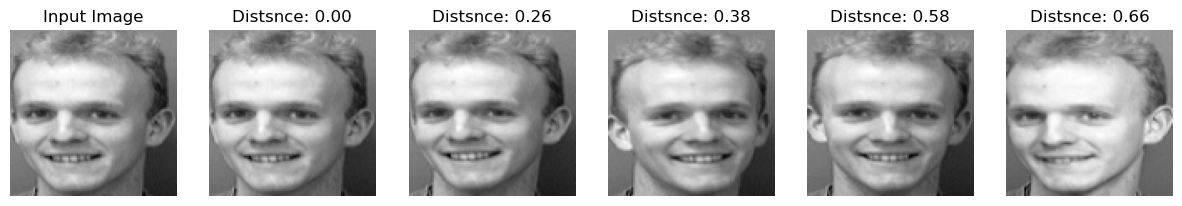

In [ ]:
# Function to preprocess and load the user-provided image
def load_user_image(file_path, transform):
    image = Image.open(file_path).convert("L")
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image

def display_top_matches(input_img, dataset, top_matches):
    fig, axes = plt.subplots(1, len(top_matches) + 1, figsize=(15, 5))

    # Input image
    axes[0].imshow(input_img.squeeze(0), cmap='gray')  # Grayscale display
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    # Top matches
    for i, (img, score) in enumerate(top_matches):
        axes[i + 1].imshow(img.squeeze(0), cmap='gray')  # Grayscale display
        axes[i + 1].set_title(f"Distsnce: {score:.2f}")
        axes[i + 1].axis("off")

    plt.show()
# Main function for comparing the user image with the dataset
def find_top_matches(model, dataset, input_image_path, top_k=5):
    transform = transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()])

    # Load user image
    input_img = load_user_image(input_image_path, transform)
    input_img_var = Variable(input_img)

    # Prepare DataLoader
    dataloader = DataLoader(dataset, num_workers=0, batch_size=1, shuffle=False)

    # Compare input image to all dataset images
    similarities = []
    seen_images = set()
    for idx, (img1, _, _) in enumerate(dataloader):
        img1_tensor = img1.squeeze(0)  # Remove batch dimension
        # Convert tensor to a hashable type to check uniqueness
        img_hash = torch.sum(img1_tensor).item()

        if img_hash in seen_images:
            continue  # Skip if this image has already been seen

        seen_images.add(img_hash)

        img1_var = Variable(img1)
        output1, output2 = model(input_img_var, img1_var)  # Ensure model works on CPU
        distance = F.pairwise_distance(output1, output2).item()
        similarities.append((img1_tensor, distance))

    # Sort by similarity (lower distance = higher similarity)
    top_matches = sorted(similarities, key=lambda x: x[1])[:top_k]

    # Display top matches
    display_top_matches(input_img.squeeze(0), dataset, top_matches)


# Call the function
# Fix file path quotes
input_image_path = input("Enter the file path of the image to compare: ").strip('"')

find_top_matches(model, siamese_dataset, input_image_path, top_k=5)

Enter the file path of the image to compare:  "C:\\Users\\jissr\\Desktop\\FP\\faces\\training\\s2\\1.pgm.png"


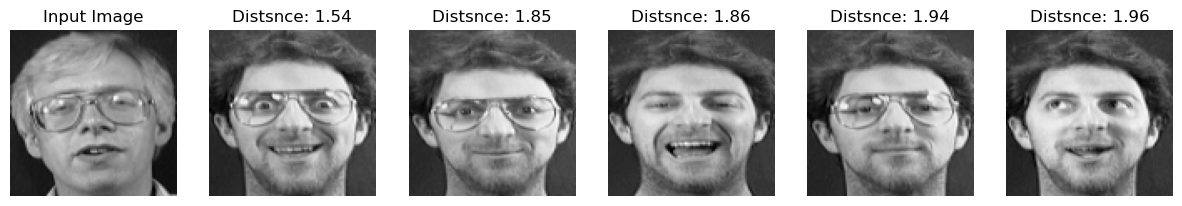

In [ ]:
# Function to preprocess and load the user-provided image
def load_user_image(file_path, transform):
    image = Image.open(file_path).convert("L")
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image

def display_top_matches(input_img, dataset, top_matches):
    fig, axes = plt.subplots(1, len(top_matches) + 1, figsize=(15, 5))

    # Input image
    axes[0].imshow(input_img.squeeze(0), cmap='gray')  # Grayscale display
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    # Top matches
    for i, (img, score) in enumerate(top_matches):
        axes[i + 1].imshow(img.squeeze(0), cmap='gray')  # Grayscale display
        axes[i + 1].set_title(f"Distsnce: {score:.2f}")
        axes[i + 1].axis("off")

    plt.show()
# Main function for comparing the user image with the dataset
def find_top_matches(model, dataset, input_image_path, top_k=5):
    transform = transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()])

    # Load user image
    input_img = load_user_image(input_image_path, transform)
    input_img_var = Variable(input_img)

    # Prepare DataLoader
    dataloader = DataLoader(dataset, num_workers=0, batch_size=1, shuffle=False)

    # Compare input image to all dataset images
    similarities = []
    seen_images = set()
    for idx, (img1, _, _) in enumerate(dataloader):
        img1_tensor = img1.squeeze(0)  # Remove batch dimension
        # Convert tensor to a hashable type to check uniqueness
        img_hash = torch.sum(img1_tensor).item()

        if img_hash in seen_images:
            continue  # Skip if this image has already been seen

        seen_images.add(img_hash)

        img1_var = Variable(img1)
        output1, output2 = model(input_img_var, img1_var)  # Ensure model works on CPU
        distance = F.pairwise_distance(output1, output2).item()
        similarities.append((img1_tensor, distance))

    # Sort by similarity (lower distance = higher similarity)
    top_matches = sorted(similarities, key=lambda x: x[1])[:top_k]

    # Display top matches
    display_top_matches(input_img.squeeze(0), dataset, top_matches)


# Call the function
# Fix file path quotes
input_image_path = input("Enter the file path of the image to compare: ").strip('"')

find_top_matches(model, siamese_dataset, input_image_path, top_k=5)

# APPLYING LOCAL THRESHOLDING TO INCREASE ACCURACY

In [ ]:
class SiameseDataset(Dataset):

    def __init__(self, image_folder, transform=None, invert=False):
        """
        Initializes the dataset with the folder containing images.

        Args:
            image_folder: The folder containing images.
            transform: Torchvision transformations to be applied.
            invert: Whether to invert the images (if using grayscale).
        """
        self.image_folder = image_folder
        self.transform = transform
        self.invert = invert

    def apply_gaussian_thresholding(self, image):
        """
        Applies Gaussian smoothing and binary thresholding to an image.

        Args:
            image: A PIL image or numpy array.

        Returns:
            Preprocessed image as a numpy array.
        """
        # Convert to grayscale if not already
        if image.mode != "L":
            image = image.convert("L")

        # Convert to numpy array
        image_np = np.array(image)

        # Apply Gaussian Blur
        blurred = cv2.GaussianBlur(image_np, (5, 5), 0)

        # Apply binary thresholding
        _, thresholded = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)

        return Image.fromarray(thresholded)

    def __getitem__(self, index):
        """
        Fetches the image pair and label (same/different).

        Args:
            index: The index of the data item.

        Returns:
            A tuple of (image1, image2, label).
        """
        sample_1 = random.choice(self.image_folder.imgs)
        same_class = random.randint(0, 1)

        if same_class:
            while True:
                sample_2 = random.choice(self.image_folder.imgs)
                if sample_1[1] == sample_2[1]:
                    break
        else:
            while True:
                sample_2 = random.choice(self.image_folder.imgs)
                if sample_1[1] != sample_2[1]:
                    break

        # Load images
        image1 = Image.open(sample_1[0])
        image2 = Image.open(sample_2[0])

        # Apply Gaussian and thresholding
        image1 = self.apply_gaussian_thresholding(image1)
        image2 = self.apply_gaussian_thresholding(image2)

        # Apply additional transformations, if any
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)

        label = torch.from_numpy(np.array([int(same_class)], dtype=np.float32))
        return image1, image2, label

    def __len__(self):
        return len(self.image_folder.imgs)

In [ ]:
iteration = 0
loss_history = []
counter = []

In [ ]:
class ConfigClass():
    train_dir = 'C:\\Users\\jissr\\Desktop\\FP\\faces\\training\\'
    test_dir = 'C:\\Users\\jissr\\Desktop\\FP\\faces\\testing\\'
    train_batch_size = 64
    train_num_epochs = 5

Epoch: 1/5 	 Loss: 0.0000
Epoch: 1/5 	 Loss: 0.0000
Epoch: 1/5 	 Loss: 0.0000
Epoch: 1/5 	 Loss: 902.3489
Epoch: 1/5 	 Loss: 144.3553
Epoch: 1/5 	 Loss: 22.8663
Epoch: 1/5 	 Loss: 210.6260
Epoch: 1/5 	 Loss: 743.0890
Epoch: 1/5 	 Loss: 0.0000
Epoch: 1/5 	 Loss: 0.0000
Epoch: 1/5 	 Loss: 16.4573
Epoch: 1/5 	 Loss: 0.0000
Epoch: 1/5 	 Loss: 5.6321
Epoch: 1/5 	 Loss: 288.0241
Epoch: 1/5 	 Loss: 6.9544
Epoch: 1/5 	 Loss: 5.7935
Epoch: 1/5 	 Loss: 0.0000
Epoch: 1/5 	 Loss: 0.0000
Epoch: 1/5 	 Loss: 0.0000
Epoch: 1/5 	 Loss: 91.9257
Epoch: 1/5 	 Loss: 20.0392
Epoch: 1/5 	 Loss: 67.0932
Epoch: 1/5 	 Loss: 64.1889
Epoch: 1/5 	 Loss: 57.7227
Epoch: 1/5 	 Loss: 14.0489
Epoch: 1/5 	 Loss: 0.0000
Epoch: 1/5 	 Loss: 219.4649
Epoch: 1/5 	 Loss: 0.0000
Epoch: 1/5 	 Loss: 0.0000
Epoch: 1/5 	 Loss: 103.8022
Epoch: 2/5 	 Loss: 76.0591
Epoch: 2/5 	 Loss: 23.4925
Epoch: 2/5 	 Loss: 11.8859
Epoch: 2/5 	 Loss: 13.9753
Epoch: 2/5 	 Loss: 97.8839
Epoch: 2/5 	 Loss: 0.0000
Epoch: 2/5 	 Loss: 4.5577
Epoch: 2/5 

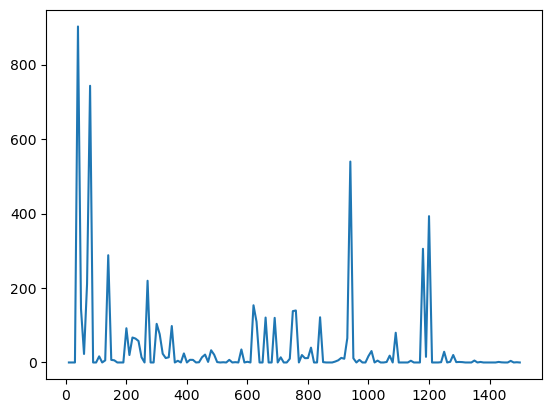

In [ ]:
# Training loop (on CPU)
for epoch in range(ConfigClass.train_num_epochs):
    for i, data in enumerate(dataloader, 0):
        input1, input2, label = data


        optimizer.zero_grad()

        # Forward pass
        output1, output2 = model(input1, input2)

        # Compute contrastive loss
        contrastive_loss = criterion(output1, output2, label)

        # Backward pass
        contrastive_loss.backward()
        optimizer.step()

        # Print loss every 10 iterations
        if (i+1) % 2 == 0:
            print(f"Epoch: {epoch+1}/{ConfigClass.train_num_epochs} \t Loss: {contrastive_loss.item():.4f}")

            iteration += 10
            loss_history.append(contrastive_loss.item())
            counter.append(iteration)

# Plot the loss over time
show_plot(counter, loss_history)

Enter the file path of the image to compare:  "C:\\Users\\jissr\\Desktop\\FP\\faces\\testing\\s5\\1.pgm.png"


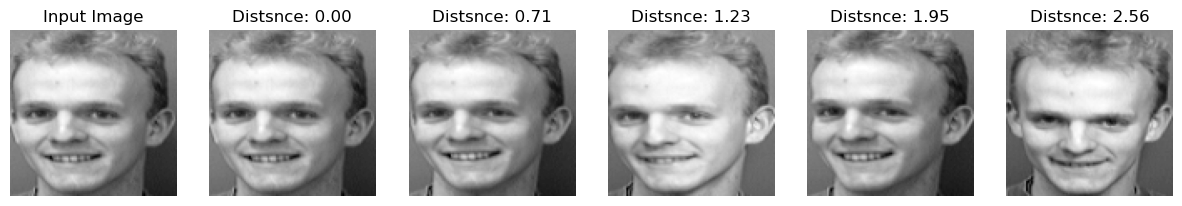

In [ ]:
# Function to preprocess and load the user-provided image
def load_user_image(file_path, transform):
    image = Image.open(file_path).convert("L")
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image

def display_top_matches(input_img, dataset, top_matches):
    fig, axes = plt.subplots(1, len(top_matches) + 1, figsize=(15, 5))

    # Input image
    axes[0].imshow(input_img.squeeze(0), cmap='gray')  # Grayscale display
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    # Top matches
    for i, (img, score) in enumerate(top_matches):
        axes[i + 1].imshow(img.squeeze(0), cmap='gray')  # Grayscale display
        axes[i + 1].set_title(f"Distsnce: {score:.2f}")
        axes[i + 1].axis("off")

    plt.show()
# Main function for comparing the user image with the dataset
def find_top_matches(model, dataset, input_image_path, top_k=5):
    transform = transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()])

    # Load user image
    input_img = load_user_image(input_image_path, transform)
    input_img_var = Variable(input_img)

    # Prepare DataLoader
    dataloader = DataLoader(dataset, num_workers=0, batch_size=1, shuffle=False)

    # Compare input image to all dataset images
    similarities = []
    seen_images = set()
    for idx, (img1, _, _) in enumerate(dataloader):
        img1_tensor = img1.squeeze(0)  # Remove batch dimension
        # Convert tensor to a hashable type to check uniqueness
        img_hash = torch.sum(img1_tensor).item()

        if img_hash in seen_images:
            continue  # Skip if this image has already been seen

        seen_images.add(img_hash)

        img1_var = Variable(img1)
        output1, output2 = model(input_img_var, img1_var)  # Ensure model works on CPU
        distance = F.pairwise_distance(output1, output2).item()
        similarities.append((img1_tensor, distance))

    # Sort by similarity (lower distance = higher similarity)
    top_matches = sorted(similarities, key=lambda x: x[1])[:top_k]

    # Display top matches
    display_top_matches(input_img.squeeze(0), dataset, top_matches)


# Call the function
# Fix file path quotes
input_image_path = input("Enter the file path of the image to compare: ").strip('"')

find_top_matches(model, siamese_dataset, input_image_path, top_k=5)

# INFERENCE:
Clearly you can see tha after thresholding the loss function have become very polarized as in least or extreme as the network could be predicting the same value for all inputs, leading to zero or very low loss in many cases. This could happen if the input images lack variability.

However the images were correctly obtained but you can see how distance between images have significantly increased

# APPLYING GLOBAL THRESHOLDING

In [ ]:
class SiameseDataset(Dataset):

    def __init__(self, image_folder, transform=None, invert=False):
        """
        Initializes the dataset with the folder containing images.

        Args:
            image_folder: The folder containing images.
            transform: Torchvision transformations to be applied.
            invert: Whether to invert the images (if using grayscale).
        """
        self.image_folder = image_folder
        self.transform = transform
        self.invert = invert

    def apply_gaussian_thresholding(self, image):
        """
        Applies Gaussian smoothing and global thresholding to an image.

        Args:
            image: A PIL image or numpy array.

        Returns:
            Preprocessed image as a numpy array.
        """
        # Convert to grayscale if not already
        if image.mode != "L":
            image = image.convert("L")

        # Convert to numpy array
        image_np = np.array(image)

        # Apply Gaussian Blur
        blurred = cv2.GaussianBlur(image_np, (5, 5), 0)

        # Compute global threshold value using Otsu's method
        _, thresholded = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        return Image.fromarray(thresholded)

    def __getitem__(self, index):
        """
        Fetches the image pair and label (same/different).

        Args:
            index: The index of the data item.

        Returns:
            A tuple of (image1, image2, label).
        """
        sample_1 = random.choice(self.image_folder.imgs)
        same_class = random.randint(0, 1)

        if same_class:
            while True:
                sample_2 = random.choice(self.image_folder.imgs)
                if sample_1[1] == sample_2[1]:
                    break
        else:
            while True:
                sample_2 = random.choice(self.image_folder.imgs)
                if sample_1[1] != sample_2[1]:
                    break

        # Load images
        image1 = Image.open(sample_1[0])
        image2 = Image.open(sample_2[0])

        # Apply Gaussian and thresholding
        image1 = self.apply_gaussian_thresholding(image1)
        image2 = self.apply_gaussian_thresholding(image2)

        # Apply additional transformations, if any
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)

        label = torch.from_numpy(np.array([int(same_class)], dtype=np.float32))
        return image1, image2, label

    def __len__(self):
        return len(self.image_folder.imgs)


In [ ]:
iteration = 0
loss_history = []
counter = []

Epoch: 1/5 	 Loss: 0.2054
Epoch: 1/5 	 Loss: 0.0000
Epoch: 1/5 	 Loss: 1.2592
Epoch: 1/5 	 Loss: 0.0000
Epoch: 1/5 	 Loss: 1.3224
Epoch: 1/5 	 Loss: 2.0721
Epoch: 1/5 	 Loss: 0.0000
Epoch: 1/5 	 Loss: 0.0000
Epoch: 1/5 	 Loss: 11.0644
Epoch: 1/5 	 Loss: 0.0000
Epoch: 1/5 	 Loss: 2.3516
Epoch: 1/5 	 Loss: 33.8141
Epoch: 1/5 	 Loss: 0.2674
Epoch: 1/5 	 Loss: 0.2058
Epoch: 1/5 	 Loss: 0.0000
Epoch: 1/5 	 Loss: 1.7165
Epoch: 1/5 	 Loss: 0.0000
Epoch: 1/5 	 Loss: 0.0000
Epoch: 1/5 	 Loss: 0.0000
Epoch: 1/5 	 Loss: 0.0000
Epoch: 1/5 	 Loss: 0.0000
Epoch: 1/5 	 Loss: 0.0000
Epoch: 1/5 	 Loss: 2.0293
Epoch: 1/5 	 Loss: 0.0000
Epoch: 1/5 	 Loss: 3.8781
Epoch: 1/5 	 Loss: 0.0000
Epoch: 1/5 	 Loss: 0.5612
Epoch: 1/5 	 Loss: 4.0169
Epoch: 1/5 	 Loss: 0.0000
Epoch: 1/5 	 Loss: 2.5123
Epoch: 2/5 	 Loss: 0.0000
Epoch: 2/5 	 Loss: 0.0000
Epoch: 2/5 	 Loss: 1.6273
Epoch: 2/5 	 Loss: 0.0000
Epoch: 2/5 	 Loss: 5.3914
Epoch: 2/5 	 Loss: 0.0000
Epoch: 2/5 	 Loss: 0.0000
Epoch: 2/5 	 Loss: 0.0000
Epoch: 2/5

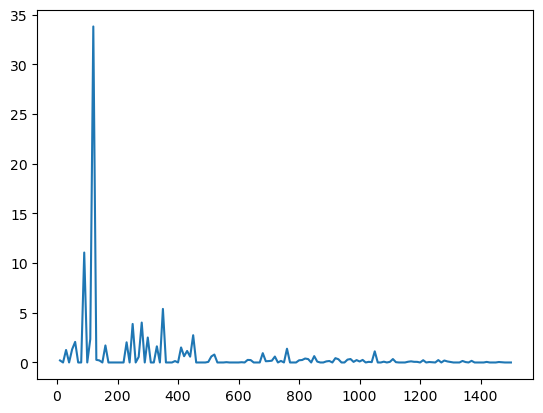

In [ ]:
# Training loop (on CPU)
for epoch in range(ConfigClass.train_num_epochs):
    for i, data in enumerate(dataloader, 0):
        input1, input2, label = data


        optimizer.zero_grad()

        # Forward pass
        output1, output2 = model(input1, input2)

        # Compute contrastive loss
        contrastive_loss = criterion(output1, output2, label)

        # Backward pass
        contrastive_loss.backward()
        optimizer.step()

        # Print loss every 10 iterations
        if (i+1) % 2 == 0:
            print(f"Epoch: {epoch+1}/{ConfigClass.train_num_epochs} \t Loss: {contrastive_loss.item():.4f}")

            iteration += 10
            loss_history.append(contrastive_loss.item())
            counter.append(iteration)

# Plot the loss over time
show_plot(counter, loss_history)

Enter the file path of the image to compare:  "C:\\Users\\jissr\\Desktop\\FP\\faces\\testing\\s5\\1.pgm.png"


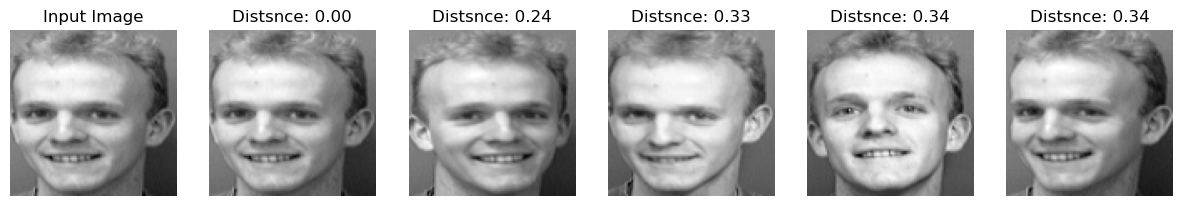

In [ ]:
# Function to preprocess and load the user-provided image
def load_user_image(file_path, transform):
    image = Image.open(file_path).convert("L")
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image

def display_top_matches(input_img, dataset, top_matches):
    fig, axes = plt.subplots(1, len(top_matches) + 1, figsize=(15, 5))

    # Input image
    axes[0].imshow(input_img.squeeze(0), cmap='gray')  # Grayscale display
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    # Top matches
    for i, (img, score) in enumerate(top_matches):
        axes[i + 1].imshow(img.squeeze(0), cmap='gray')  # Grayscale display
        axes[i + 1].set_title(f"Distsnce: {score:.2f}")
        axes[i + 1].axis("off")

    plt.show()
# Main function for comparing the user image with the dataset
def find_top_matches(model, dataset, input_image_path, top_k=5):
    transform = transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()])

    # Load user image
    input_img = load_user_image(input_image_path, transform)
    input_img_var = Variable(input_img)

    # Prepare DataLoader
    dataloader = DataLoader(dataset, num_workers=0, batch_size=1, shuffle=False)

    # Compare input image to all dataset images
    similarities = []
    seen_images = set()
    for idx, (img1, _, _) in enumerate(dataloader):
        img1_tensor = img1.squeeze(0)  # Remove batch dimension
        # Convert tensor to a hashable type to check uniqueness
        img_hash = torch.sum(img1_tensor).item()

        if img_hash in seen_images:
            continue  # Skip if this image has already been seen

        seen_images.add(img_hash)

        img1_var = Variable(img1)
        output1, output2 = model(input_img_var, img1_var)  # Ensure model works on CPU
        distance = F.pairwise_distance(output1, output2).item()
        similarities.append((img1_tensor, distance))

    # Sort by similarity (lower distance = higher similarity)
    top_matches = sorted(similarities, key=lambda x: x[1])[:top_k]

    # Display top matches
    display_top_matches(input_img.squeeze(0), dataset, top_matches)


# Call the function
# Fix file path quotes
input_image_path = input("Enter the file path of the image to compare: ").strip('"')

find_top_matches(model, siamese_dataset, input_image_path, top_k=5)

# INFERENCE:

CLearly much better performance than regular or local thresholding was observed when we did global thresholding because of the absence of lighting effects in these images.  This can be understood from the fact that we obtained same persons image with a lower distance